In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from allen_v1dd.client import OPhysClient
from v1dd_public import ARTIFACT_DIR
import scipy.stats as stats
import statsmodels.stats.multicomp as multi
from scipy.stats import bootstrap
from statsmodels.stats.multicomp import pairwise_tukeyhsd as multi_pairwise_tukeyhsd
from scipy.stats import ks_2samp
from scipy.stats import ttest_ind
from matplotlib.colors import LinearSegmentedColormap
import os

np.random.seed(42)

In [23]:
## plotting parameters
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"

fontsize=13
figure_path = Path('/home/naomi/Desktop/figures/v1dd_plots')

In [24]:
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]
H5_DIR = os.path.join(ARTIFACT_DIR, 'stimulus_analyses_v2.h5')
DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs")
client =  OPhysClient(DATA_DIR)

In [5]:
csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    # remove duplicate neurons
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

In [33]:
res2 = ['frac_resp_dgf',
        'frac_resp_dgw',
        'frac_res_to_ns118', # please note the other fraction frac_resp_ns118 is from Chase h5 which is incorrect
        'frac_res_to_ns12', # please note the other fraction frac_resp_ns12 is from Chase h5 which is incorrect
        'frac_resp_nm'
       ]
features = cell_info[res2]  # features is a dataframe with the 7 response reliability fractions (columns) for every cell (rows) across all mice

features = features.rename(columns = {
       'frac_resp_dgf':'DGF',
       'frac_resp_dgw':'DGW',
       'frac_res_to_ns118':'NI118',
       'frac_res_to_ns12':'NI12',
       'frac_resp_nm':'NM'})

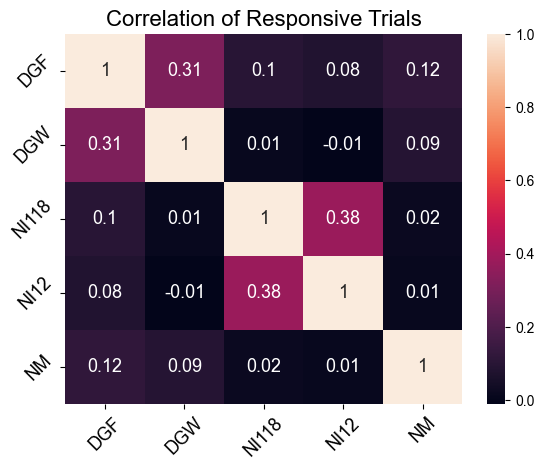

In [34]:
corrMatrix = features.corr()        # compute the correlation matrix (default is Pearson)
sns.heatmap(np.round(corrMatrix,2), annot_kws={"size": fontsize}, annot=True)
plt.title('Correlation of Responsive Trials', fontsize=16)
plt.xticks(fontsize=fontsize, rotation=45)
plt.yticks(fontsize=fontsize, rotation=45)
# plt.show()

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', 'FIG5A_correlation_of_responsive_trials.png'), dpi=300)

If for any reason the numbers are not shown in the correlation matrix run: pip install --upgrade seaborn matplotlib!

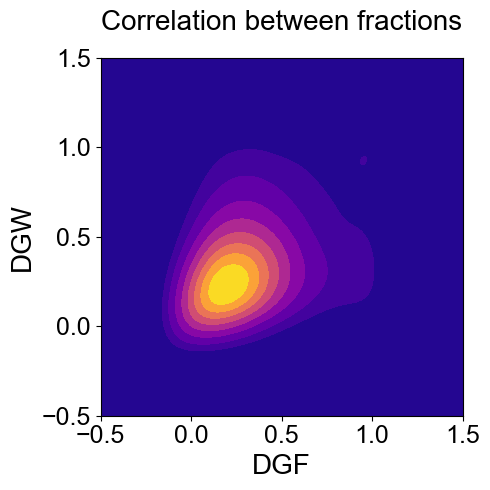

In [35]:
feature1 = 'DGF'
feature2 = 'DGW'

plt.figure(figsize=(5, 5))
correlation = features[feature1].corr(features[feature2])
sns.kdeplot(x=features[feature1], y=features[feature2], cmap='plasma', fill=True, thresh=0, bw_adjust=2.5, levels=10, cut=10)
font = 20
plt.xlabel("DGF", fontsize=font)
plt.ylabel("DGW", fontsize=font)
plt.xticks([-0.5, 0, 0.5, 1, 1.5], fontsize=font-2)
plt.yticks([-0.5, 0, 0.5, 1, 1.5], fontsize=font-2)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.title("Correlation between fractions", fontsize=font, pad=20)
plt.tight_layout()

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', 'FIG5B_correlation_DGF_DGW.svg'), dpi=300)

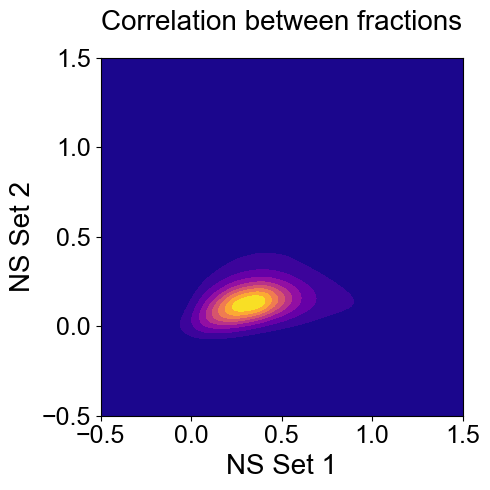

In [36]:
feature1 = 'NI118'
feature2 = 'NI12'

plt.figure(figsize=(5, 5))
correlation = features[feature1].corr(features[feature2])
sns.kdeplot(x=features[feature1], y=features[feature2], cmap='plasma', fill=True, thresh=0, bw_adjust=2.5, levels=10, cut=10)
font=20
plt.xlabel("NS Set 1", fontsize=font)
plt.ylabel("NS Set 2", fontsize=font)
plt.xticks([-0.5, 0, 0.5, 1, 1.5], fontsize=font-2)
plt.yticks([-0.5, 0, 0.5, 1, 1.5], fontsize=font-2)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.title(f"Correlation between fractions", fontsize=font, pad=20)
plt.tight_layout()

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', 'FIG5B_correlation_NS1NS2.svg'), dpi=300)

### Top correlations wrt depth

In [158]:
def perform_anova(filtered_data):
    f_value, p_value = stats.f_oneway(*filtered_data)
    return f_value, p_value

def perform_tukeys_hsd_and_top_pairs(filtered_data, p_val):
    all_data = np.concatenate(filtered_data)
    groups = np.concatenate([np.full(len(sublist), i) for i, sublist in enumerate(filtered_data)])

    # Perform Tukey's HSD test
    tukey_result = multi.pairwise_tukeyhsd(all_data, groups, 0.05)
    tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
    significant_pairs = tukey_df[tukey_df['p-adj'] < p_val]
    significant_pairs_sorted = significant_pairs.sort_values(by='p-adj')


    print("\nTukey's HSD test result:")
    print(tukey_result)
    print(f"\nPairs with p-values < {p_val}: {len(significant_pairs_sorted)} found")
    print(significant_pairs_sorted)
    
    return tukey_result, significant_pairs_sorted.to_records(index=False)

### Define the stmulus pairs from csv columns for performing correlation analysis

In [39]:
res3 = ['mouse_id',
        'frac_resp_dgf',
        'frac_resp_dgw',
        'frac_res_to_ns118', # please note the other fraction frac_resp_ns118 is from Chase h5 which is incorrect
        'frac_res_to_ns12', # please note the other fraction frac_resp_ns12 is from Chase h5 which is incorrect
        'frac_resp_nm',
        'z'
       ]
features = cell_info[res3]  # features is a dataframe with the 7 response reliability fractions (columns) for every cell (rows) across all mice

features = features.rename(columns = {
       'frac_resp_dgf':'DGF',
       'frac_resp_dgw':'DGW',
       'frac_res_to_ns118':'NI118',
       'frac_res_to_ns12':'NI12',
       'frac_resp_nm':'NM',
       'z':'depth'})

In [44]:
pairs = [['DGW', 'DGF'], ['DGW', 'NI12'], ['DGW', 'NI118'], ['NI12', 'NI118']]


In [45]:
features

,mouse_id,DGF,DGW,NI118,NI12,NM,depth
0,slc2,0.142857,0.375000,0.625,0.475,0.750000,500
1,slc2,0.000000,0.000000,0.125,0.050,0.125000,500
2,slc2,0.285714,0.250000,0.125,0.125,1.000000,500
3,slc2,0.500000,0.142857,0.750,0.325,1.000000,500
4,slc2,0.000000,0.000000,0.250,0.050,0.875000,500
...,...,...,...,...,...,...,...
88346,teto1,0.375000,0.375000,0.250,0.150,0.375000,514
88347,teto1,0.142857,0.333333,0.375,0.175,0.555556,514
88348,teto1,0.500000,0.125000,0.375,0.150,0.500000,514
88349,teto1,0.250000,0.333333,0.500,0.150,0.250000,514


In [116]:
depths = features.depth.unique()
depths = [depth for depth in depths if depth != 500 and depth <= 514]
depths = np.array(depths)
depths.sort()
depths

array([ 50,  66,  82,  98, 114, 130, 146, 162, 178, 194, 210, 226, 242,
       258, 274, 290, 306, 322, 338, 354, 370, 386, 402, 418, 434, 450,
       466, 482, 498, 514])

In [127]:
n_pairs = len(pairs)
n_bootstrap = 1000
boot_size = 50
depths = features.depth.unique()
depths = [depth for depth in depths if depth != 500 and depth <= 514]
depths = np.array(depths)
depths.sort()
n_depths = len(depths)
mice = features.mouse_id.unique()
n_mice = len(mice)
rng = np.random.default_rng()
# bootstrapped_data = np.zeros((n_pairs, n_mice, n_depths, n_bootstrap))
bootstrapped_data = np.empty(n_bootstrap, dtype=float)
results = {
    'mouse_id': [],
    'depth': [],
    'feature1': [],
    'feature2': [],
    'bootstrap_correlations': []
}

for m, mouse_id in enumerate(mice):
    for z, depth in enumerate(depths):
        data = features[(features.mouse_id == mouse_id) & (features.depth == depth)]
        for p, (feature1, feature2) in enumerate(pairs):
            data1 = data[feature1].values
            data2 = data[feature2].values
            n1 = len(data1)
            n2 = len(data2)
            if n1 > boot_size and n2 > boot_size:
                for b in range(n_bootstrap):
                    sample_indices = np.random.choice(range(len(data1)), size=boot_size, replace=True)
                    sampled1 = data1[sample_indices]
                    sampled2 = data2[sample_indices]
                    bootstrapped_data[b] = np.corrcoef(sampled1, sampled2)[0, 1]
            else:
                bootstrapped_data[:] = np.nan

            results['mouse_id'].append(mouse_id)
            results['depth'].append(depth)
            results['feature1'].append(feature1)
            results['feature2'].append(feature2)
            results['bootstrap_correlations'].append(bootstrapped_data.copy())

results_df = pd.DataFrame(
    data=[
        np.repeat(np.array(results['mouse_id']), n_bootstrap),
        np.repeat(np.array(results['depth']), n_bootstrap),
        np.repeat(np.array(results['feature1']), n_bootstrap),
        np.repeat(np.array(results['feature2']), n_bootstrap),
        np.concatenate(results['bootstrap_correlations'])
    ]
).T

results_df = results_df.rename(columns={
    0: 'mouse_id',
    1: 'depth',
    2: 'feature1',
    3: 'feature2',
    4: 'bootstrap_correlation'
})

In [128]:
results_df

,mouse_id,depth,feature1,feature2,bootstrap_correlation
0,slc2,50,DGW,DGF,NaN
1,slc2,50,DGW,DGF,NaN
2,slc2,50,DGW,DGF,NaN
3,slc2,50,DGW,DGF,NaN
4,slc2,50,DGW,DGF,NaN
...,...,...,...,...,...
479995,teto1,514,NI12,NI118,0.083075
479996,teto1,514,NI12,NI118,0.384541
479997,teto1,514,NI12,NI118,0.027233
479998,teto1,514,NI12,NI118,0.297533


In [129]:
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}

/tmp/ipykernel_3275324/1496526629.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['depth'] = temp_df['depth'] + np.random.normal(0, jitter_amount, size=len(temp_df))
/tmp/ipykernel_3275324/1496526629.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['depth'] = temp_df['depth'] + np.random.normal(0, jitter_amount, size=len(temp_df))
/tmp/ipykernel_3275324/1496526629.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

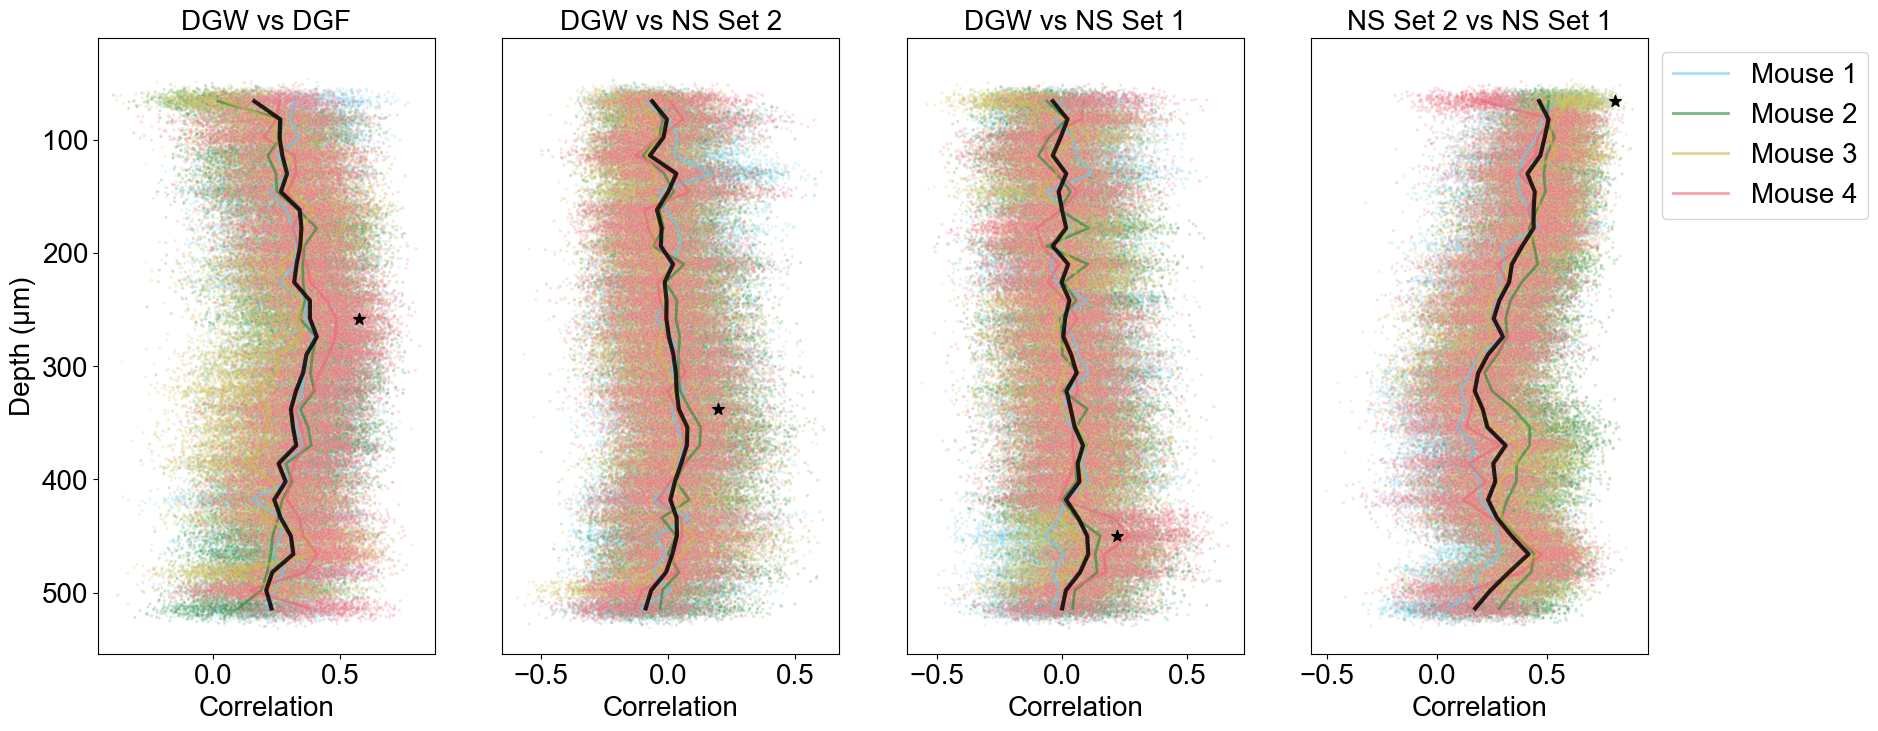

In [136]:
#### Plotting decoding accuracies for each mouse

# Some parameters for the plot
z_values = results_df['depth'].unique()
z_values = np.array(z_values)
z_values = np.sort(z_values)
# titles = ['DGF', 'DGW', 'NS Set 1', 'NS Set 2']
stim_to_title = {
    'DGF': 'DGF',
    'DGW': 'DGW',
    'NI118': 'NS Set 1',
    'NI12': 'NS Set 2'
}
n_stims = 4
jitter_amount = 5

fig, axs = plt.subplots(1, n_stims, figsize=(20, 8))
fontsize = 20

# Iterate through each stimulus type and plot the results for all the mice
for idx, (feature1, feature2) in enumerate(pairs):
    ax = axs[idx]

    temp_df = results_df[(results_df['feature1'] == feature1) & (results_df['feature2'] == feature2)]

    sns.lineplot(
        data=temp_df,
        x='bootstrap_correlation',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors,
        linewidth=2, 
        errorbar=None, 
        alpha=0.6, 
        orient='y', 
        markers=True,
        ax=ax,
        legend=False if idx != 3 else True,
    )

    ax.legend(handles=plt.gca().get_legend_handles_labels()[0], labels=['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], 
        loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize, title_fontsize=fontsize) if idx == 3 else None

    sns.lineplot(data=temp_df, 
        x='bootstrap_correlation', 
        y='depth', 
        color='black', 
        estimator='mean',
        err_style='band', 
        errorbar='se', 
        linewidth=3, 
        alpha=0.8, 
        orient='y', 
        ax=ax, 
        legend=False
    )

    # Put asterisk next to the depth where the max mean
    sub_df = temp_df.groupby('depth')['bootstrap_correlation'].mean().reset_index()
    sub_array = sub_df['bootstrap_correlation'].values
    sub_array = sub_array[~np.isnan(sub_array)]
    axs[idx].scatter(sub_array.max() + 3*sub_array.std(), sub_df.iloc[np.where(sub_array == sub_array.max())].depth.values[0], 
        color='black', marker='*', s=75, edgecolor='black', zorder=1)
    
    temp_df['depth'] = temp_df['depth'] + np.random.normal(0, jitter_amount, size=len(temp_df))

    sns.scatterplot(data=temp_df,
        x='bootstrap_correlation',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors,
        s=5,
        alpha=0.2,
        ax=ax,
        legend=False,
        zorder=0,
    )

    # ax.set_title(titles[stim_type], fontsize=fontsize)
    ax.set_title(f'{stim_to_title[feature1]} vs {stim_to_title[feature2]}', fontsize=fontsize)
    ax.set_xlabel('Correlation', fontsize=fontsize)
    ax.set_ylabel("Depth (µm)", fontsize=fontsize) if idx == 0 else ax.set_ylabel(" ")
    ax.set_yticks([]) if idx != 0 else None
    ax.set_ylim(z_values.min() - 40, z_values.max() + 40)
    # ax.set_xlim(left=0, right=0.8) if idx != 2 else ax.set_xlim(left=0, right=0.25)
    ax.tick_params(axis="both", which="major", labelsize=fontsize)
    ax.invert_yaxis()

# plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'FIG2D_nobootstrapping_1plane_valaccuracies_decoding.svg'), dpi=300)

array([0.16131867, 0.26323416, 0.26063558, 0.27187349, 0.29037477,
       0.26599328, 0.34000116, 0.34706553, 0.34233206, 0.327812  ,
       0.31849836, 0.38048608, 0.38064373, 0.4076949 , 0.36654057,
       0.3535277 , 0.32536722, 0.30553192, 0.31379009, 0.32674981,
       0.25681843, 0.28477897, 0.23970891, 0.2652813 , 0.30533981,
       0.31504701, 0.23204992, 0.20812081, 0.22914439])

In [ ]:
n_stimulus_pairs = len(stimulus_data_pairs)
n_bootstrap = 1000
n_z_groups = len(z_groups_high_to_low)
n_mice = len(mice)
bootstrapped_data = np.zeros((n_stimulus_pairs, n_bootstrap, n_z_groups, n_mice))

for m, mouse_id in enumerate(mice):
    for z, z_group in enumerate(z_groups_high_to_low):
        plane = cell_info['z'].isin(z_group) & (cell_info['mouse_id']==mice[m])
        combined_datasets = [
            (cell_info[plane]["frac_res_to_on"].dropna().values, cell_info[plane]["frac_res_to_off"].dropna().values),
            (cell_info[plane]["frac_resp_dgf"].dropna().values, cell_info[plane]["frac_resp_dgw"].dropna().values),
            (cell_info[plane]["frac_res_to_ns118"].dropna().values, cell_info[plane]["frac_res_to_ns12"].dropna().values),
            (cell_info[plane]["frac_resp_nm"].dropna().values, cell_info[plane]["frac_resp_dgf"].dropna().values),
            (cell_info[plane]["frac_resp_nm"].dropna().values, cell_info[plane]["frac_resp_dgw"].dropna().values),
            (cell_info[plane]["frac_resp_nm"].dropna().values, cell_info[plane]["frac_res_to_off"].dropna().values),
            (cell_info[plane]["frac_resp_nm"].dropna().values, cell_info[plane]["frac_res_to_ns118"].dropna().values)
        ]

        for i, (data_x, data_y) in enumerate(combined_datasets):
                if len(data_x) > 1 and len(data_y) > 1:

                    for b in range(n_bootstrap):
                        sample_indices = np.random.choice(range(len(data_x)), size=50, replace=True)
                        sampled_x = data_x[sample_indices]
                        sampled_y = data_y[sample_indices]
                        corr_coef = np.corrcoef(sampled_x, sampled_y)[0, 1]
                        bootstrapped_data[i, b, z, m] = corr_coef

In [39]:
# Some parameters for the plot
z_values = features_2['depth'].unique()
z_values = np.array(z_values)
z_values = np.sort(z_values)
stims = ['LSN-ON', 'LSN-OFF', 'DGF', 'DGW', 'NI118', 'NI12', 'NM']
titles = ['LSN-ON', 'LSN-OFF', 'DGF', 'DGW', 'NS Set 1', 'NS Set 2', 'NM']

In [42]:
from itertools import combinations

features_3 = features_2.copy()
for pair in combinations(stims, 2):
    print(pair)
    features_3[f'{pair[0]}_{pair[1]}'] = np.corrcoef(features_2[pair[0]], features_2[pair[1]])[0, 1]

('LSN-ON', 'LSN-OFF')
('LSN-ON', 'DGF')
('LSN-ON', 'DGW')
('LSN-ON', 'NI118')
('LSN-ON', 'NI12')
('LSN-ON', 'NM')
('LSN-OFF', 'DGF')
('LSN-OFF', 'DGW')
('LSN-OFF', 'NI118')
('LSN-OFF', 'NI12')
('LSN-OFF', 'NM')
('DGF', 'DGW')
('DGF', 'NI118')
('DGF', 'NI12')
('DGF', 'NM')
('DGW', 'NI118')
('DGW', 'NI12')
('DGW', 'NM')
('NI118', 'NI12')
('NI118', 'NM')
('NI12', 'NM')


In [44]:
np.corrcoef(features_2[pair[0]], features_2[pair[1]])

array([[1.        , 0.04295445],
       [0.04295445, 1.        ]])

In [ ]:
titles = ["LSN-ON/LSN-OFF", "DGF/DGW", "NS Set1/NS Set2", "NM/DGF", "NM/DGW", "NM/LSN-OFF", "NM/NI Set1"]

for z, z_group in enumerate(z_groups_high_to_low):

    plane = cell_info['z'].isin(z_group)
    combined_data1 = cell_info[plane]["frac_res_to_on"].dropna().values
    combined_data2 = cell_info[plane]["frac_res_to_off"].dropna().values
    combined_data3 = cell_info[plane]["frac_resp_dgf"].dropna().values
    combined_data4 = cell_info[plane]["frac_resp_dgw"].dropna().values
    combined_data5 = cell_info[plane]["frac_res_to_ns118"].dropna().values
    combined_data6 = cell_info[plane]["frac_res_to_ns12"].dropna().values
    combined_data7 = cell_info[plane]["frac_resp_nm"].dropna().values


stimulus_data_pairs = [
    (combined_data1, combined_data2),
    (combined_data3, combined_data4),
    (combined_data5, combined_data6),
    (combined_data7, combined_data3),
    (combined_data7, combined_data4),
    (combined_data7, combined_data2),
    (combined_data7, combined_data5)
]

for pair in stimulus_data_pairs:

In [ ]:
#### Plotting decoding accuracies for each mouse

# Some parameters for the plot
z_values = features_2['depth'].unique()
z_values = np.array(z_values)
z_values = np.sort(z_values)
stims = ['LSN-ON', 'LSN-OFF', 'DGF', 'DGW', 'NI118', 'NI12', 'NM']
titles = ['LSN-ON', 'LSN-OFF', 'DGF', 'DGW', 'NS Set 1', 'NS Set 2', 'NM']
n_stims = len(stims)
jitter_amount = 5

fig, axs = plt.subplots(1, n_stims, figsize=(25, 8))
fontsize = 20

# Iterate through each stimulus type and plot the results for all the mice
for stim_idx, stim_type in enumerate(stims):
    ax = axs[stim_idx]

    sns.lineplot(
        data=features_2,
        x=stim_type,
        y='depth',
        hue='mouse_id',
        palette=mouse_colors,
        linewidth=2, 
        errorbar=None, 
        alpha=0.6, 
        orient='y', 
        markers=True,
        ax=ax,
        legend=False # if stim_idx != int(n_stims-1) else True,
    )

    # ax.legend(handles=plt.gca().get_legend_handles_labels()[0], labels=['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], 
    #     loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize, title_fontsize=fontsize) if stim_idx == int(n_stims-1) else None

    sns.lineplot(data=features_2, 
        x=stim_type, 
        y='depth', 
        color='black', 
        estimator='mean',
        err_style='band', 
        errorbar='se', 
        linewidth=3, 
        alpha=0.8, 
        orient='y', 
        ax=ax, 
        legend=False
    )

    # Put asterisk next to the depth where the max mean
    # sub_df = features_2.groupby('depth')[stim_type].mean().reset_index()
    # sub_array = sub_df[stim_type].values
    # ax.scatter(sub_array.max() + 3*sub_array.std(), sub_df.iloc[np.where(sub_array == sub_array.max())].depth.values[0], 
    #     color='black', marker='*', s=75, edgecolor='black', zorder=1)
    

    # Scatterplot of all the individual points
    temp_df = features_2.copy()
    temp_df['depth'] = temp_df['depth'] + np.random.normal(0, 7, size=len(temp_df))
    temp_df[stim_type] = temp_df[stim_type] + np.random.normal(0, 0.05, size=len(temp_df))

    sns.scatterplot(data=temp_df,
        x=stim_type,
        y='depth',
        hue='mouse_id',
        palette=mouse_colors,
        s=6,
        alpha=0.25,
        ax=ax,
        legend=False,
        zorder=0,
    )

    ax.set_title(titles[stim_idx], fontsize=fontsize)
    ax.set_xlabel('Fraction', fontsize=fontsize)
    ax.set_ylabel("Depth (µm)", fontsize=fontsize) if stim_idx == 0 else ax.set_ylabel(" ")
    ax.set_yticks([]) if stim_idx != 0 else None
    ax.set_ylim(z_values.min() - 40, z_values.max() + 40)
    ax.set_xlim(0, 1)
    ax.tick_params(axis="both", which="major", labelsize=fontsize)
    ax.invert_yaxis()

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'FIG5B_resp_fractions_depth_trends.png'), dpi=300)

### Find 1000 bootstraps (index b), for each stimulus pair (index i), for each depth (index z), and each mouse (index m)

In [162]:
n_stimulus_pairs = len(stimulus_data_pairs)
n_bootstrap = 1000
n_z_groups = len(z_groups_high_to_low)
n_mice = len(mice)
bootstrapped_data = np.zeros((n_stimulus_pairs, n_bootstrap, n_z_groups, n_mice))

for m, mouse_id in enumerate(mice):
    for z, z_group in enumerate(z_groups_high_to_low):
        plane = cell_info['z'].isin(z_group) & (cell_info['mouse_id']==mice[m])
        combined_datasets = [
            (cell_info[plane]["frac_res_to_on"].dropna().values, cell_info[plane]["frac_res_to_off"].dropna().values),
            (cell_info[plane]["frac_resp_dgf"].dropna().values, cell_info[plane]["frac_resp_dgw"].dropna().values),
            (cell_info[plane]["frac_res_to_ns118"].dropna().values, cell_info[plane]["frac_res_to_ns12"].dropna().values),
            (cell_info[plane]["frac_resp_nm"].dropna().values, cell_info[plane]["frac_resp_dgf"].dropna().values),
            (cell_info[plane]["frac_resp_nm"].dropna().values, cell_info[plane]["frac_resp_dgw"].dropna().values),
            (cell_info[plane]["frac_resp_nm"].dropna().values, cell_info[plane]["frac_res_to_off"].dropna().values),
            (cell_info[plane]["frac_resp_nm"].dropna().values, cell_info[plane]["frac_res_to_ns118"].dropna().values)
        ]

        for i, (data_x, data_y) in enumerate(combined_datasets):
                if len(data_x) > 1 and len(data_y) > 1:

                    for b in range(n_bootstrap):
                        sample_indices = np.random.choice(range(len(data_x)), size=50, replace=True)
                        sampled_x = data_x[sample_indices]
                        sampled_y = data_y[sample_indices]
                        corr_coef = np.corrcoef(sampled_x, sampled_y)[0, 1]
                        bootstrapped_data[i, b, z, m] = corr_coef

### Find 1000 bootstraps (index b), for each stimulus pair (index i), and for each depth (index z), aggregate all 4 mice

In [163]:
n_stimulus_pairs = len(stimulus_data_pairs)
n_bootstrap = 1000
n_z_groups = len(z_groups_high_to_low)
bootstrapped_data_all_mice = np.zeros((n_stimulus_pairs, n_bootstrap, n_z_groups))

# Loop over each z_group and compute bootstrapped correlations for each stimulus pair
for z, z_group in enumerate(z_groups_high_to_low):
    plane = cell_info['z'].isin(z_group)
    combined_datasets = [
        (cell_info[plane]["frac_res_to_on"].dropna().values, cell_info[plane]["frac_res_to_off"].dropna().values),
        (cell_info[plane]["frac_resp_dgf"].dropna().values, cell_info[plane]["frac_resp_dgw"].dropna().values),
        (cell_info[plane]["frac_res_to_ns118"].dropna().values, cell_info[plane]["frac_res_to_ns12"].dropna().values),
        (cell_info[plane]["frac_resp_nm"].dropna().values, cell_info[plane]["frac_resp_dgf"].dropna().values),
        (cell_info[plane]["frac_resp_nm"].dropna().values, cell_info[plane]["frac_resp_dgw"].dropna().values),
        (cell_info[plane]["frac_resp_nm"].dropna().values, cell_info[plane]["frac_res_to_off"].dropna().values),
        (cell_info[plane]["frac_resp_nm"].dropna().values, cell_info[plane]["frac_res_to_ns118"].dropna().values)
    ]

    for i, (data_x, data_y) in enumerate(combined_datasets):
            if len(data_x) > 1 and len(data_y) > 1:
                for b in range(n_bootstrap):
                    sample_indices = np.random.choice(range(len(data_x)), size=50, replace=True)
                    sampled_x = data_x[sample_indices]
                    sampled_y = data_y[sample_indices]
                    corr_coef = np.corrcoef(sampled_x, sampled_y)[0, 1]
                    bootstrapped_data_all_mice[i, b, z] = corr_coef

### Plot the bootstraped correlations with respect to depth

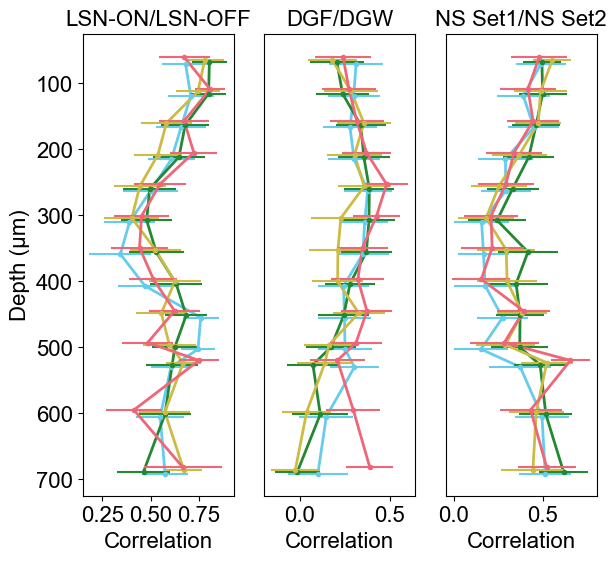

In [164]:
fig = plt.figure(figsize=(16, 6))
jitter_amount = 5
num_elements = len(mice)
jitter_step = jitter_amount * 2 / (num_elements - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, num_elements)
fixed_jitters = np.tile(jitter_values, (n_z_groups, 1))

for s in range(3):
    ax = plt.subplot(1, n_stimulus_pairs, s + 1)
    
    for m, mouse_id in enumerate(mice):

        means = []
        std_errors = []
        mouse_color = mouse_colors[mice[m]]
        
        for z in range(n_z_groups):
            bootstrapped_values = bootstrapped_data[s, :, z, m]
            mean = np.mean(bootstrapped_values)
            std = np.std(bootstrapped_values)
            
            means.append(mean)
            std_errors.append(std)

        jitter = fixed_jitters[:, 3-m]
        y_positions = np.array([int(np.mean(x)) for x in z_groups_high_to_low]) + jitter
        
        plt.errorbar(means, y_positions, xerr=std_errors, fmt='o', color=mouse_color, ecolor=mouse_color, capsize=0, markersize=3)
        plt.plot(means, y_positions, color=mouse_color, linewidth=2)

        plt.xlabel('Correlation', fontsize=fontsize)
        plt.title(titles[s], fontsize=fontsize, fontname='Arial')
    
    if s == 0:
        plt.yticks(fontsize=fontsize)
        plt.ylabel("Depth (µm)", fontsize=fontsize)
    else:
        plt.yticks([])
    
    plt.xticks(fontsize=fontsize)
    plt.ylim(25, 725)
    plt.gca().invert_yaxis()

fig.savefig(f"/home/naomi/Desktop/figures/v1dd_plots/3Dcorrelation_of_fractions_new_jitters_with_lines.eps", 
            format='eps', bbox_inches='tight', dpi=300)

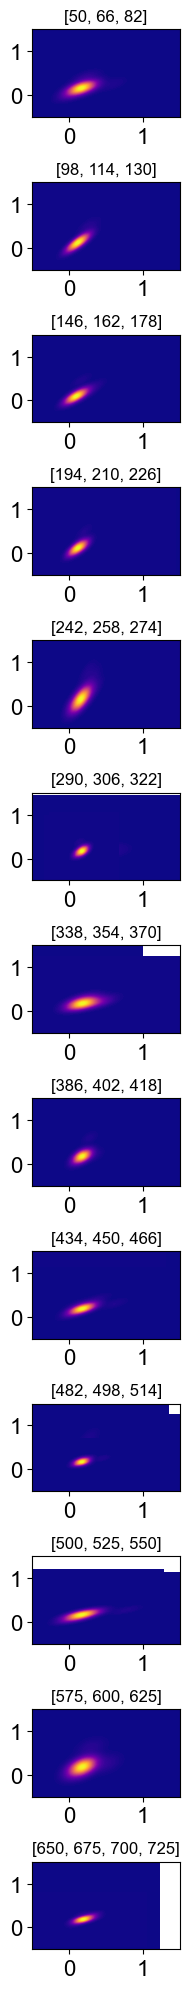

In [165]:
n_mice = len(mice)
fig, axs = plt.subplots(13, 1, figsize=(2, 20))

for m, mouse_id in enumerate(mice):
    for z, z_group in enumerate(z_groups_low_to_high):
        if z < 13:
            ax = axs[z]
            plane = cell_info['z'].isin(z_group) & (cell_info['mouse_id'] == mouse_id)
            combined_datasets = [
                (cell_info[plane]["frac_res_to_on"].dropna().values, cell_info[plane]["frac_res_to_off"].dropna().values)]

            for i, (data_x, data_y) in enumerate(combined_datasets):
                if len(data_x) > 1 and len(data_y) > 1:
                    sample_indices = np.random.choice(range(len(data_x)), size=50, replace=True)
                    sampled_x = data_x[sample_indices]
                    sampled_y = data_y[sample_indices]
                    sns.kdeplot(x=sampled_x, y=sampled_y, cmap='plasma', fill=True, thresh=0, bw_adjust=2.5, levels=100, cut=10, ax=ax)
                    ax.set_xlim(-0.5, 1.5)
                    ax.set_ylim(-0.5, 1.5)
                    ax.set_title(f"{z_group}")
                    ax.tick_params(axis='both', which='major', labelsize=fontsize)
                else:
                    ax.set_title(f"{z_group} (insufficient data)")

plt.tight_layout()
plt.savefig(os.path.join(figure_path, '3D_sample_correlations_ontooff.eps'), dpi=300)

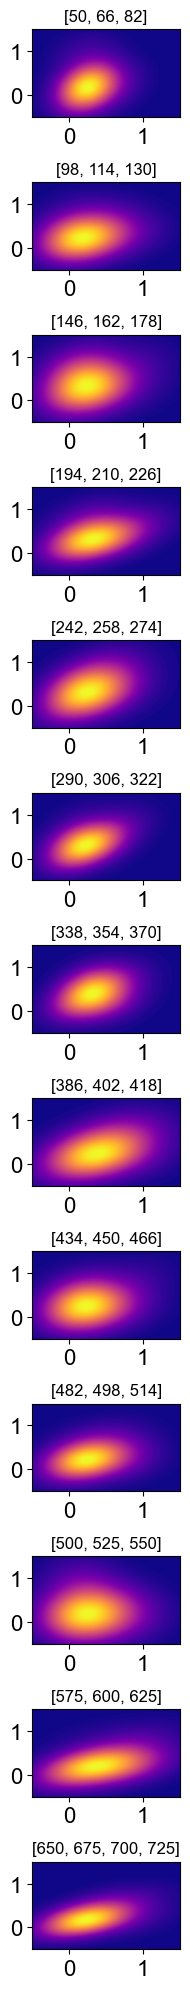

In [166]:
n_mice = len(mice)
fig, axs = plt.subplots(13, 1, figsize=(2, 20))

for m, mouse_id in enumerate(mice):
    for z, z_group in enumerate(z_groups_low_to_high):
        if z < 13:
            ax = axs[z]
            plane = cell_info['z'].isin(z_group) & (cell_info['mouse_id'] == mouse_id)
            combined_datasets = [(cell_info[plane]["frac_resp_dgf"].dropna().values, cell_info[plane]["frac_resp_dgw"].dropna().values)]

            for i, (data_x, data_y) in enumerate(combined_datasets):
                if len(data_x) > 1 and len(data_y) > 1:
                    sample_indices = np.random.choice(range(len(data_x)), size=50, replace=True)
                    sampled_x = data_x[sample_indices]
                    sampled_y = data_y[sample_indices]
                    sns.kdeplot(x=sampled_x, y=sampled_y, cmap='plasma', fill=True, thresh=0, bw_adjust=2.5, levels=100, cut=10, ax=ax)
                    ax.set_xlim(-0.5, 1.5)
                    ax.set_ylim(-0.5, 1.5)
                    ax.set_title(f"{z_group}")
                    ax.tick_params(axis='both', which='major', labelsize=fontsize)
                else:
                    ax.set_title(f"{z_group} (insufficient data)")

plt.tight_layout()

plt.savefig(os.path.join(figure_path, '3D_sample_correlations_dgftodgw.eps'), dpi=300)

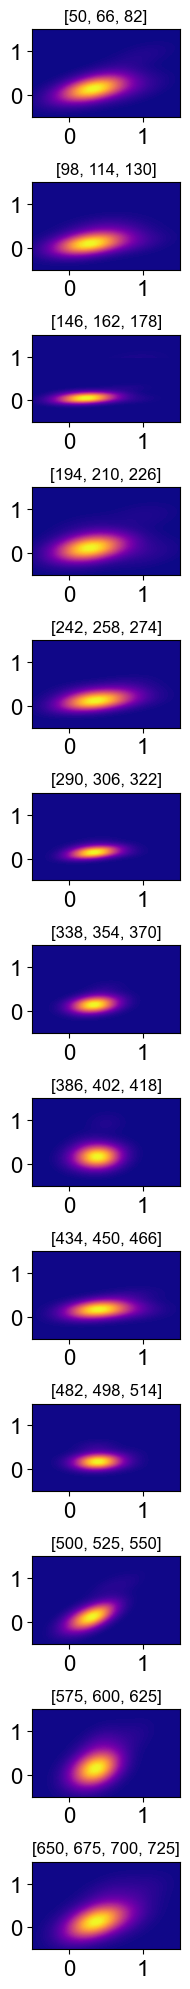

In [167]:
n_mice = len(mice)
fig, axs = plt.subplots(13, 1, figsize=(2, 20))

for m, mouse_id in enumerate(mice):
    for z, z_group in enumerate(z_groups_low_to_high):
        if z < 13:
            ax = axs[z]
            plane = cell_info['z'].isin(z_group) & (cell_info['mouse_id'] == mouse_id)
            combined_datasets = [(cell_info[plane]["frac_res_to_ns118"].dropna().values, cell_info[plane]["frac_res_to_ns12"].dropna().values)]

            for i, (data_x, data_y) in enumerate(combined_datasets):
                if len(data_x) > 1 and len(data_y) > 1:
                    sample_indices = np.random.choice(range(len(data_x)), size=50, replace=True)
                    sampled_x = data_x[sample_indices]
                    sampled_y = data_y[sample_indices]
                    sns.kdeplot(x=sampled_x, y=sampled_y, cmap='plasma', fill=True, thresh=0, bw_adjust=2.5, levels=100, cut=10, ax=ax)
                    ax.set_xlim(-0.5, 1.5)
                    ax.set_ylim(-0.5, 1.5)
                    ax.set_title(f"{z_group}")
                    ax.tick_params(axis='both', which='major', labelsize=fontsize)
                else:
                    ax.set_title(f"{z_group} (insufficient data)")

plt.tight_layout()
plt.savefig(os.path.join(figure_path, '3D_sample_correlations_ns118tons12.eps'), dpi=300)

### Depth related statistics

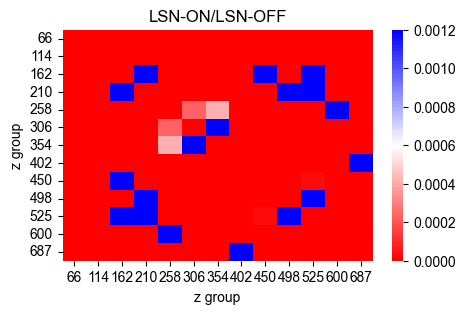

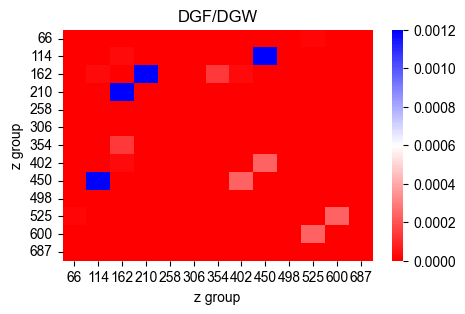

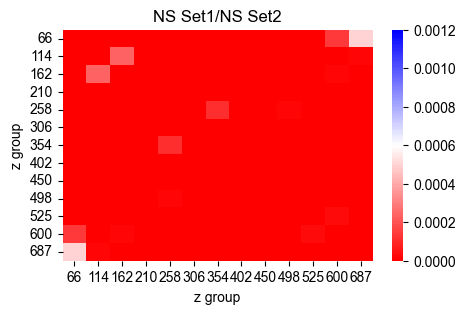

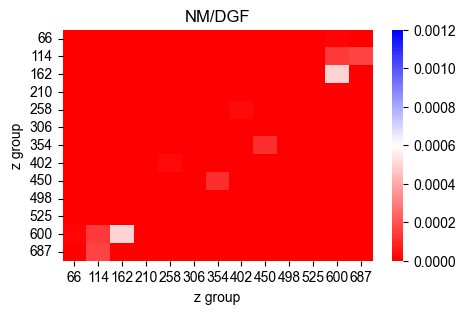

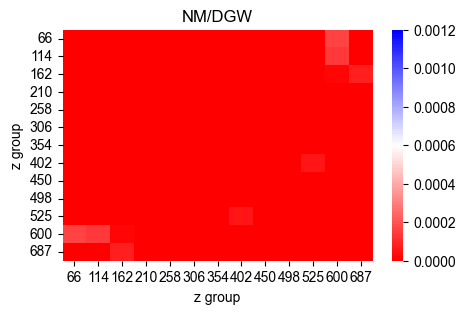

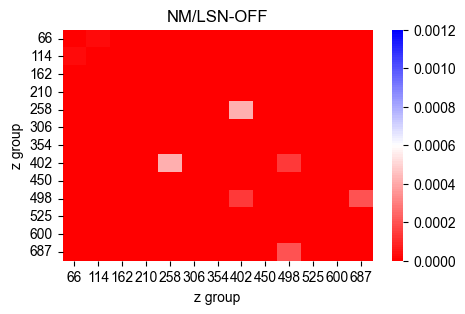

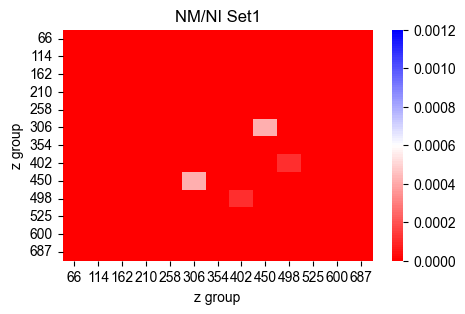

In [168]:
colors = ["red", "white", "blue"]
n_bins = 100
cmap_name = "custom_colormap"
p_val = 0.0006#0.05/78
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
vmin, vmax = 0, p_val*2
norm = plt.Normalize(vmin=vmin, vmax=vmax)
num_elements = len(mice)
p_value_matrix = np.ones((13, 13))
titles = ["LSN-ON/LSN-OFF", "DGF/DGW", "NS Set1/NS Set2", "NM/DGF", "NM/DGW", "NM/LSN-OFF", "NM/NI Set1"]
y_tick_labels = [int(np.mean(x)) for x in z_groups_high_to_low]
y_tick_labels = np.flip(y_tick_labels)

for s in range(7):
    data_to_plot = [bootstrapped_data_all_mice[s, :, z] for z in range(n_z_groups)]
    significant_pairs = []
    # Pairwise Kolmogorov-Smirnov tests
    for i in range(len(data_to_plot)):
        for j in range(i+1, len(data_to_plot)):
            ks_stat, p_value = ks_2samp(data_to_plot[i], data_to_plot[j])

            if p_value < p_val:
                significant_pairs.append((i, j, p_value))
                p_value_matrix[j, i] = p_value
                p_value_matrix[i, j] = p_value

    np.fill_diagonal(p_value_matrix, 0)
    plt.figure(figsize=(5, 3))
    p_value_matrix = np.flip(np.flip(p_value_matrix, axis=0), axis=1)
    sns.heatmap(p_value_matrix, annot=False, cmap=cm, norm = norm, cbar=True,
                 xticklabels=y_tick_labels, yticklabels=y_tick_labels)

    plt.title(titles[s])
    plt.xlabel('z group')
    plt.ylabel('z group')
    plt.savefig(os.path.join(figure_path, f'3D_KS_p_values_{s}.eps'), dpi=300)

Try t-test to verify the ks test

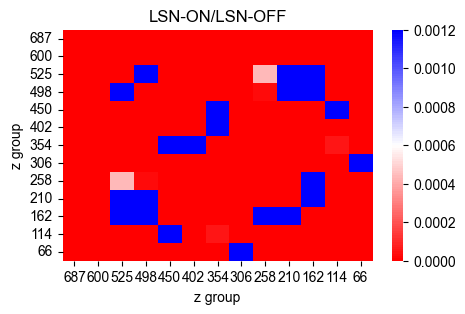

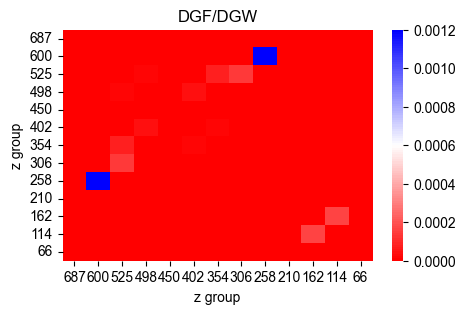

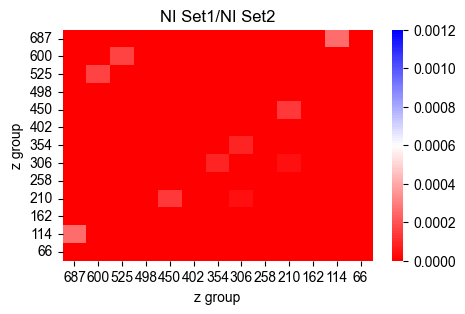

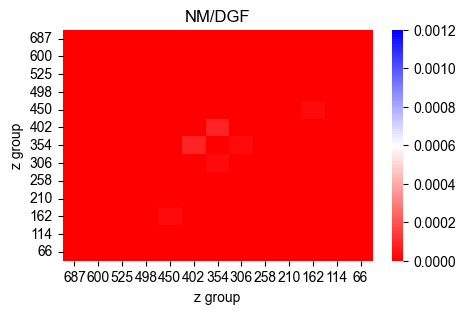

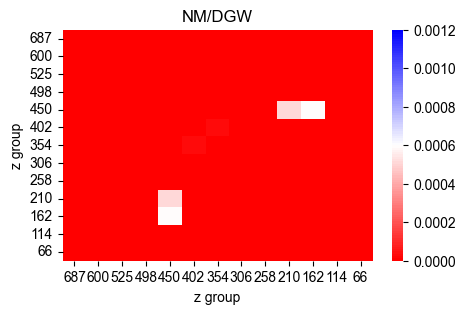

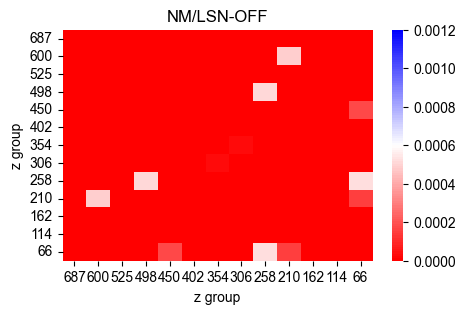

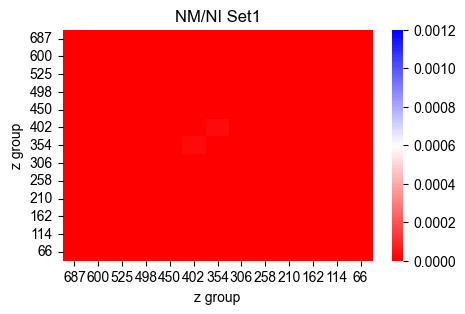

In [169]:

n_stimulus_pairs = len(stimulus_data_pairs)
n_bootstrap = 1000
n_z_groups = len(z_groups_high_to_low)
bootstrapped_data_all_mice = np.zeros((n_stimulus_pairs, n_bootstrap, n_z_groups))
for z, z_group in enumerate(z_groups_high_to_low):
    plane = cell_info['z'].isin(z_group)
    combined_datasets = [
        (cell_info[plane]["frac_res_to_on"].dropna().values, cell_info[plane]["frac_res_to_off"].dropna().values),
        (cell_info[plane]["frac_resp_dgf"].dropna().values, cell_info[plane]["frac_resp_dgw"].dropna().values),
        (cell_info[plane]["frac_res_to_ns118"].dropna().values, cell_info[plane]["frac_res_to_ns12"].dropna().values),
        (cell_info[plane]["frac_resp_nm"].dropna().values, cell_info[plane]["frac_resp_dgf"].dropna().values),
        (cell_info[plane]["frac_resp_nm"].dropna().values, cell_info[plane]["frac_resp_dgw"].dropna().values),
        (cell_info[plane]["frac_resp_nm"].dropna().values, cell_info[plane]["frac_res_to_off"].dropna().values),
        (cell_info[plane]["frac_resp_nm"].dropna().values, cell_info[plane]["frac_res_to_ns118"].dropna().values)
    ]

    for i, (data_x, data_y) in enumerate(combined_datasets):
            if len(data_x) > 1 and len(data_y) > 1:
                for b in range(n_bootstrap):
                    sample_indices = np.random.choice(range(len(data_x)), size=50, replace=True)
                    sampled_x = data_x[sample_indices]
                    sampled_y = data_y[sample_indices]
                    corr_coef = np.corrcoef(sampled_x, sampled_y)[0, 1]
                    bootstrapped_data_all_mice[i, b, z] = corr_coef
                    
                    
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
colors = ["red", "white", "blue"]
n_bins = 100
cmap_name = "custom_colormap"
p_val = 0.0006#0.05/78
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
vmin, vmax = 0, p_val*2
norm = plt.Normalize(vmin=vmin, vmax=vmax)


num_elements = len(mice)
p_value_matrix = np.ones((13, 13))
titles = ["LSN-ON/LSN-OFF", "DGF/DGW", "NI Set1/NI Set2", "NM/DGF", "NM/DGW", "NM/LSN-OFF", "NM/NI Set1"]
y_tick_labels = np.flip(y_tick_labels)

for s in range(7):

    data_to_plot = [bootstrapped_data_all_mice[s, :, z] for z in range(n_z_groups)]
    significant_pairs = []

    # Pairwise t-test with multiple comparisons
    for i in range(len(data_to_plot)):
        for j in range(i+1, len(data_to_plot)):
            t_stat, p_value = ttest_ind(data_to_plot[i], data_to_plot[j])

            if p_value < p_val:
                significant_pairs.append((i, j, p_value))
                p_value_matrix[j, i] = p_value
                p_value_matrix[i, j] = p_value

    np.fill_diagonal(p_value_matrix, 0)
    plt.figure(figsize=(5, 3))
    p_value_matrix = np.flip(np.flip(p_value_matrix, axis=0), axis=1)
    sns.heatmap(p_value_matrix, annot=False, cmap=cm, norm = norm, cbar=True,
                 xticklabels=y_tick_labels, yticklabels=y_tick_labels)

    plt.title(titles[s])
    plt.xlabel('z group')
    plt.ylabel('z group')
    plt.show()

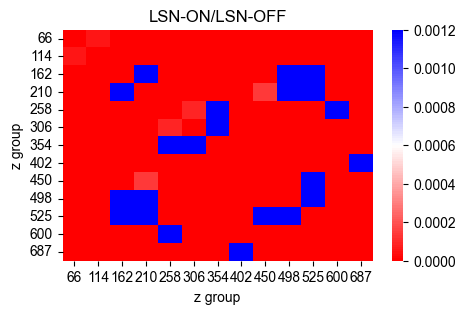

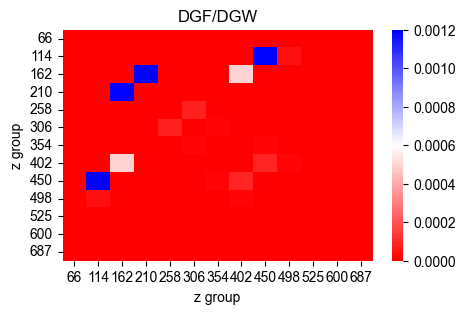

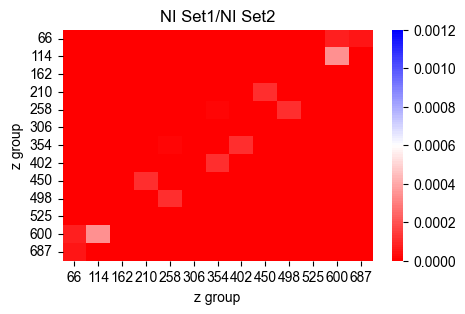

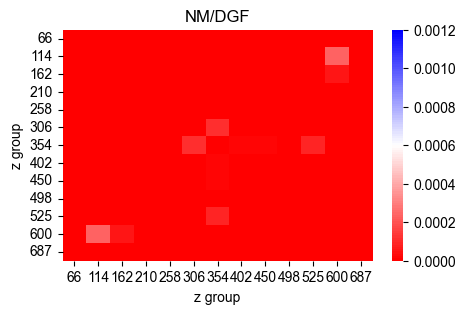

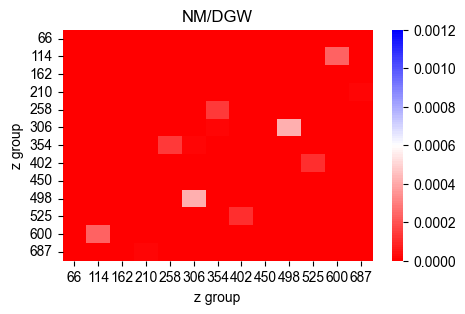

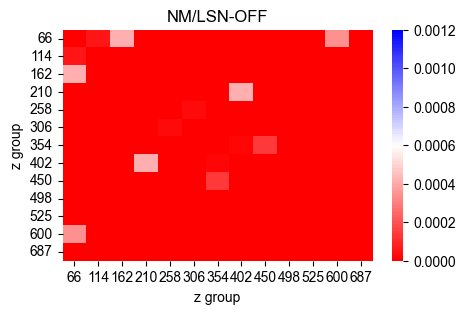

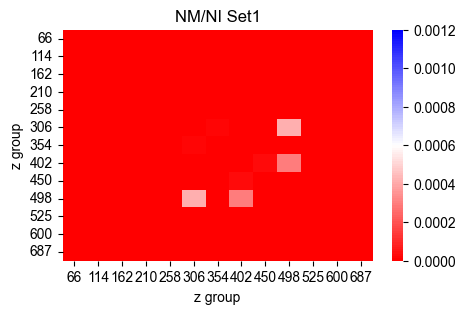

In [170]:
colors = ["red", "white", "blue"]
n_bins = 100
cmap_name = "custom_colormap"
p_val = 0.0006#0.05/78
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
vmin, vmax = 0, p_val*2
norm = plt.Normalize(vmin=vmin, vmax=vmax)
num_elements = len(mice)
p_value_matrix = np.ones((13, 13))
titles = ["LSN-ON/LSN-OFF", "DGF/DGW", "NI Set1/NI Set2", "NM/DGF", "NM/DGW", "NM/LSN-OFF", "NM/NI Set1"]
y_tick_labels = np.flip(y_tick_labels)

for s in range(7):

    data_to_plot = [bootstrapped_data_all_mice[s, :, z] for z in range(n_z_groups)]
    significant_pairs = []

    # Pairwise Kolmogorov-Smirnov tests
    for i in range(len(data_to_plot)):
        for j in range(i+1, len(data_to_plot)):
            t_stat, p_value = ks_2samp(data_to_plot[i], data_to_plot[j])

            if p_value < p_val:
                significant_pairs.append((i, j, p_value))
                p_value_matrix[j, i] = p_value
                p_value_matrix[i, j] = p_value

    np.fill_diagonal(p_value_matrix, 0)
    plt.figure(figsize=(5, 3))
    p_value_matrix = np.flip(np.flip(p_value_matrix, axis=0), axis=1)
    sns.heatmap(p_value_matrix, annot=False, cmap=cm, norm = norm, cbar=True,
                 xticklabels=y_tick_labels, yticklabels=y_tick_labels)
    plt.title(titles[s])
    plt.xlabel('z group')
    plt.ylabel('z group')
    plt.show()